# 1. What is a Conformer?
The Conformer (Convolution-augmented Transformer) was introduced by Google in 2020 for speech recognition. It’s now widely used in audio and time-series domains.
* Transformer part: models global dependencies across time (self-attention).
* Convolution part: captures local correlations and inductive bias (like short-term muscle activity patterns in EMG).
* Feed-forward modules: two half-step feedforward layers wrap around the attention+conv block, improving depth and expressivity.

So the Conformer block = FFN → MHSA → Conv → FFN, with residual connections and LayerNorm.

# 2. Conformer Block Breakdown
Each block usually looks like this:
1. Feed-Forward 1 (half-step): expands then compresses features.
2.	Multi-Head Self-Attention (MHSA): learns global relationships.
3.	Convolution Module: a depthwise separable CNN + GLU activation + batch norm, good at local dependencies.
4.	Feed-Forward 2 (half-step).
5.	Residual & LayerNorm at each stage.

# 3. Conformer for EMG
Adapting it for EMG sequences (time × channels):
* Input: (B, T, C) → project to d_model like before.
* Positional encoding: sinusoidal or learnable.
* Stack of Conformer blocks (n_layers = 2–4 is a good start).
* Pooling: CLS token or mean pooling.
* Classification head: LayerNorm + MLP → logits.

In [1]:
from pathlib import Path
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

ROOT = Path("..")
DATA_PROCESSED = ROOT / "data" / "processed" / "db1"
MODELS_DIR     = ROOT / "models" / "db1"
REPORTS_DIR    = ROOT / "reports" / "db1"
for p in [MODELS_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [2]:
train_npz = DATA_PROCESSED / "dl_train_db1_raw.npz"
val_npz   = DATA_PROCESSED / "dl_val_db1_raw.npz"
test_npz  = DATA_PROCESSED / "dl_test_db1_raw.npz"

ztr = np.load(train_npz, allow_pickle=True)
zva = np.load(val_npz,   allow_pickle=True)
zte = np.load(test_npz,  allow_pickle=True)

Xtr, ytr = ztr["X"], ztr["y"]    # (N, T, C)
Xva, yva = zva["X"], zva["y"]
Xte, yte = zte["X"], zte["y"]
idx_to_label = ztr["idx_to_label"]
n_classes = len(idx_to_label)

print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape, "classes:", n_classes)

# Optional: keep data small but class-balanced for CPU
def stratified_cap(X, y, per_class=200, seed=0):
    rng = np.random.default_rng(seed)
    keep = []
    for c in np.unique(y):
        idx = np.where(y == c)[0]
        take = min(per_class, len(idx))
        if take > 0:
            keep.extend(rng.choice(idx, size=take, replace=False))
    keep = np.array(keep)
    return X[keep], y[keep]

Xtr, ytr = stratified_cap(Xtr, ytr, per_class=400, seed=0)
Xva, yva = stratified_cap(Xva, yva, per_class=100, seed=1)
Xte, yte = stratified_cap(Xte, yte, per_class=100, seed=2)

print("After caps — Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape)

Train: (312643, 50, 10) Val: (93436, 50, 10) Test: (93476, 50, 10) classes: 23
After caps — Train: (9200, 50, 10) Val: (2300, 50, 10) Test: (2300, 50, 10)


In [12]:
from torch.utils.data import Dataset, DataLoader

class EMGSeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)   # (N, T, C)
        self.y = y.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.tensor(self.y[i], dtype=torch.long)

BATCH_SIZE = 128  # shrink if CPU/memory bound

train_ds = EMGSeqDataset(Xtr, ytr)
val_ds   = EMGSeqDataset(Xva, yva)
test_ds  = EMGSeqDataset(Xte, yte)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=False)

xb, yb = next(iter(train_loader))
xb.shape  # expect (B, T, C)

torch.Size([128, 50, 10])

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConformerBlock(nn.Module):
    """
    Conformer block: 0.5*FFN -> MHSA -> Conv -> 0.5*FFN with residuals.
    Shapes:
      x: (B, T, D)  where D = d_model
    """
    def __init__(self, d_model=128, n_heads=4, dim_ff=256, conv_kernel=31, dropout=0.1):
        super().__init__()
        assert conv_kernel % 2 == 1 and conv_kernel >= 3, "conv_kernel should be odd and >= 3"

        # Feed-forward #1 (half-step)
        self.ff1 = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, dim_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model),
            nn.Dropout(dropout),
        )

        # Multi-head self-attention (pre-norm)
        self.ln_mha = nn.LayerNorm(d_model)
        self.mha = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=n_heads, dropout=dropout, batch_first=True
        )

        # Convolution module (operate in (B, C, T))
        # NOTE: use BatchNorm1d (channel-wise) here; LayerNorm would expect last-dim = D
        self.conv = nn.Sequential(
            nn.Conv1d(d_model, 2 * d_model, kernel_size=1),      # pointwise
            nn.GLU(dim=1),                                       # (B, D, T)
            nn.Conv1d(d_model, d_model, kernel_size=conv_kernel,
                      padding=conv_kernel // 2, groups=d_model), # depthwise
            nn.BatchNorm1d(d_model),
            nn.SiLU(),
            nn.Conv1d(d_model, d_model, kernel_size=1),          # pointwise
            nn.Dropout(dropout),
        )

        # Feed-forward #2 (half-step)
        self.ff2 = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, dim_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # x: (B, T, D)
        x = x + 0.5 * self.ff1(x)

        # MHSA (pre-norm)
        x_norm = self.ln_mha(x)
        attn_out, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + attn_out

        # Convolution module
        conv_in = x.transpose(1, 2)          # (B, D, T)
        conv_out = self.conv(conv_in).transpose(1, 2)  # back to (B, T, D)
        x = x + conv_out

        # FFN #2 (half-step)
        x = x + 0.5 * self.ff2(x)
        return x


class EMGConformer(nn.Module):
    """
    EMG Conformer classifier:
      (B, T, C) --Linear--> (B, T, D)
      + positional encoding
      -> stack of Conformer blocks
      -> temporal pooling (mean)
      -> classification head
    """
    def __init__(self, n_features, n_classes,
                 d_model=128, n_heads=4, n_layers=2, dim_ff=256,
                 conv_kernel=31, dropout=0.1, max_len=2000, learnable_posenc=True):
        super().__init__()
        self.proj = nn.Linear(n_features, d_model)

        # Positional encoding: learnable or fixed buffer
        if learnable_posenc:
            self.pos_enc = nn.Parameter(torch.zeros(1, max_len, d_model))
            nn.init.trunc_normal_(self.pos_enc, std=0.02)
            self.use_learnable_pe = True
        else:
            # sinusoidal as a non-parameter buffer
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) *
                                 (-torch.log(torch.tensor(10000.0)) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            self.register_buffer("pos_enc", pe.unsqueeze(0))  # (1, T, D)
            self.use_learnable_pe = False

        self.blocks = nn.ModuleList([
            ConformerBlock(d_model=d_model, n_heads=n_heads,
                           dim_ff=dim_ff, conv_kernel=conv_kernel, dropout=dropout)
            for _ in range(n_layers)
        ])

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, n_classes),
        )

        self.max_len = max_len

    def forward(self, x):  # x: (B, T, C)
        h = self.proj(x)  # (B, T, D)

        T = h.size(1)
        if T > self.max_len:
            raise ValueError(f"Sequence length {T} exceeds max_len {self.max_len} of positional encoding.")
        if self.use_learnable_pe:
            h = h + self.pos_enc[:, :T, :]      # (1, T, D) broadcast
        else:
            h = h + self.pos_enc[:, :T, :]      # buffer sinusoidal (1, T, D)

        for block in self.blocks:
            h = block(h)                        # (B, T, D)

        z = h.mean(dim=1)                       # temporal mean pool
        return self.head(z)                     # (B, n_classes)

In [19]:
n_channels = Xtr.shape[2]      # input features per timestep
n_classes  = len(idx_to_label)

model = EMGConformer(
    n_features=n_channels,
    n_classes=n_classes,
    d_model=128,        # embedding dimension
    n_heads=4,          # attention heads
    n_layers=2,         # conformer blocks
    dim_ff=256,         # feedforward dimension
    conv_kernel=31,     # conv module kernel size (odd number, ~30-50 works well)
    dropout=0.2,
).to(DEVICE)

print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))

# Class weights
vals, cnts = np.unique(ytr, return_counts=True)
class_count = np.zeros(n_classes, dtype=np.float32)
class_count[vals] = cnts
weights = 1.0 / (class_count + 1e-6)
weights = torch.tensor(weights / weights.mean(), dtype=torch.float32, device=DEVICE)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

EMGConformer(
  (proj): Linear(in_features=10, out_features=128, bias=True)
  (blocks): ModuleList(
    (0-1): 2 x ConformerBlock(
      (ff1): Sequential(
        (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=128, out_features=256, bias=True)
        (2): GELU(approximate='none')
        (3): Dropout(p=0.2, inplace=False)
        (4): Linear(in_features=256, out_features=128, bias=True)
        (5): Dropout(p=0.2, inplace=False)
      )
      (ln_mha): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (conv): Sequential(
        (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
        (1): GLU(dim=1)
        (2): Conv1d(128, 128, kernel_size=(31,), stride=(1,), padding=(15,), groups=128)
        (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4

In [20]:
# One of these schedulers (optional). Pick one and comment the other.

# Cosine annealing (simple, robust)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

# or OneCycle (requires steps_per_epoch)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=3e-3, epochs=25, steps_per_epoch=len(train_loader)
# )

CLIP_NORM = 1.0  # gradient clipping for stability

In [21]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch

def run_epoch(model, loader, criterion, optimizer=None, clip_norm=None, scheduler=None, device=DEVICE):
    train_mode = optimizer is not None
    model.train(train_mode)

    total_loss = 0.0
    y_true, y_pred = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            if clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()
            if scheduler is not None:
                # Step per-batch for OneCycle; for Cosine, you can step per-epoch (below)
                if isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    scheduler.step()

        total_loss += loss.item() * xb.size(0)
        y_true.append(yb.detach().cpu().numpy())
        y_pred.append(logits.argmax(dim=1).detach().cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return total_loss / len(loader.dataset), acc, f1

In [22]:
EPOCHS   = 25
PATIENCE = 5
best_val_f1, best_state = -1.0, None
no_improve = 0
history = []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc, tr_f1 = run_epoch(
        model, train_loader, criterion,
        optimizer=optimizer, clip_norm=CLIP_NORM, scheduler=scheduler
    )

    # For cosine annealing, step per-epoch
    if isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingLR):
        scheduler.step()

    va_loss, va_acc, va_f1 = run_epoch(model, val_loader, criterion, optimizer=None)

    history.append((epoch, tr_loss, tr_acc, tr_f1, va_loss, va_acc, va_f1))
    print(f"Epoch {epoch:02d} | "
          f"train: loss {tr_loss:.4f} acc {tr_acc:.3f} f1 {tr_f1:.3f} | "
          f"val: loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")

    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping.")
            break

# Restore best
if best_state is not None:
    model.load_state_dict(best_state)

Epoch 01 | train: loss 2.8780 acc 0.141 f1 0.116 | val: loss 2.8093 acc 0.160 f1 0.131
Epoch 02 | train: loss 2.7221 acc 0.185 f1 0.168 | val: loss 2.7900 acc 0.172 f1 0.147
Epoch 03 | train: loss 2.6321 acc 0.218 f1 0.200 | val: loss 2.7546 acc 0.173 f1 0.159
Epoch 04 | train: loss 2.5562 acc 0.233 f1 0.218 | val: loss 2.7219 acc 0.194 f1 0.164
Epoch 05 | train: loss 2.4756 acc 0.252 f1 0.236 | val: loss 2.7694 acc 0.206 f1 0.185
Epoch 06 | train: loss 2.3846 acc 0.281 f1 0.268 | val: loss 2.7185 acc 0.196 f1 0.182
Epoch 07 | train: loss 2.3153 acc 0.302 f1 0.288 | val: loss 2.7291 acc 0.197 f1 0.188
Epoch 08 | train: loss 2.2277 acc 0.324 f1 0.312 | val: loss 2.7819 acc 0.198 f1 0.184
Epoch 09 | train: loss 2.1340 acc 0.349 f1 0.337 | val: loss 2.8481 acc 0.190 f1 0.180
Epoch 10 | train: loss 2.0430 acc 0.379 f1 0.368 | val: loss 2.8890 acc 0.206 f1 0.194
Epoch 11 | train: loss 1.9594 acc 0.403 f1 0.394 | val: loss 2.9980 acc 0.189 f1 0.183
Epoch 12 | train: loss 1.8453 acc 0.428 f1 

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

te_loss, te_acc, te_f1 = run_epoch(model, test_loader, criterion, optimizer=None)
print(f"Test — loss {te_loss:.4f}  acc {te_acc:.3f}  macro-F1 {te_f1:.3f}")

# Full report
y_true_all, y_pred_all = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(DEVICE)).cpu().numpy()
        y_pred_all.append(np.argmax(logits, axis=1))
        y_true_all.append(yb.numpy())
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

print(classification_report(y_true_all, y_pred_all, zero_division=0))

Test — loss 3.0221  acc 0.175  macro-F1 0.163
              precision    recall  f1-score   support

           0       0.12      0.09      0.10       100
           1       0.20      0.26      0.22       100
           2       0.15      0.07      0.09       100
           3       0.24      0.13      0.17       100
           4       0.31      0.15      0.20       100
           5       0.12      0.04      0.06       100
           6       0.19      0.13      0.15       100
           7       0.12      0.07      0.09       100
           8       0.06      0.07      0.07       100
           9       0.15      0.11      0.13       100
          10       0.12      0.07      0.09       100
          11       0.10      0.04      0.06       100
          12       0.19      0.17      0.18       100
          13       0.12      0.07      0.09       100
          14       0.15      0.21      0.18       100
          15       0.09      0.11      0.10       100
          16       0.09      0.19  

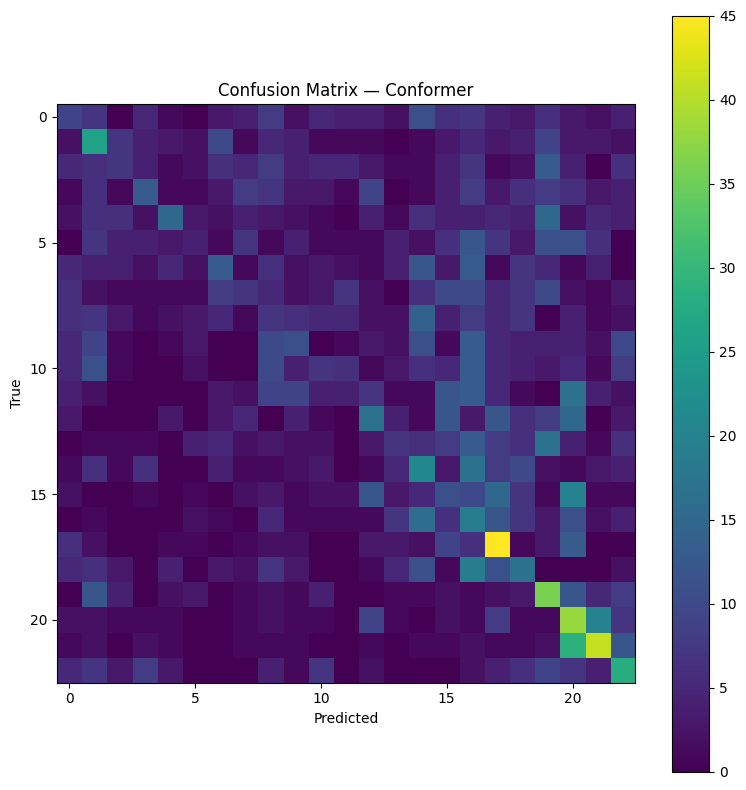

Saved: ../reports/db1/cm_conformer.png


In [24]:
cm = confusion_matrix(y_true_all, y_pred_all)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix — Conformer")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.colorbar(im, ax=ax)
plt.tight_layout()

fig_path = REPORTS_DIR / "cm_conformer.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved:", fig_path)

In [25]:
ckpt_path = MODELS_DIR / "conformer_db1.pt"
meta_path = MODELS_DIR / "conformer_db1_meta.npz"

torch.save(model.state_dict(), ckpt_path)
np.savez_compressed(meta_path,
                    n_features=n_channels,
                    n_classes=n_classes,
                    d_model=model.proj.out_features)

print("Saved model to:", ckpt_path)
print("Saved meta   to:", meta_path)

Saved model to: ../models/db1/conformer_db1.pt
Saved meta   to: ../models/db1/conformer_db1_meta.npz


In [26]:
def predict_one_window(x_np):  # x_np: (T, C) float32
    x = torch.from_numpy(x_np.astype(np.float32)).unsqueeze(0).to(DEVICE)  # (1, T, C)
    with torch.no_grad():
        logits = model(x).cpu().numpy()[0]
    return logits, logits.argmax()

logits, pred = predict_one_window(Xte[0])
print("pred idx:", pred, "true idx:", yte[0])

pred idx: 18 true idx: 0
